#### Load Necessary Libraries

In [8]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split as tts
import pandas as pd 
from numpy import loadtxt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy

from preprocess import preprocess_text
from AL import batch_creator
from AL import make_prediction
from AL import active_learning_model
from AL import active_learning

import warnings
warnings.filterwarnings("ignore")

##### Load the Labelled and Unlabelled Dataset

In [2]:
labelled_data = pd.read_csv("D://FALL 2022//CSC2515 INTRO TO ML//Active_Learning_Based_Research_Paper_Classification//data//labelled//cs_data.csv")

# Preprocessing CS data
df = labelled_data[['title', 'abstract','categories']]
df['title'] = preprocess_text(df, 'title')
df['abstract'] = preprocess_text(df, 'abstract')
df["text"] = df["title"] + df["abstract"]

labelled, unlabelled=tts(df,test_size=0.8, random_state=7)

In [4]:
# Unlabelled Dataset from arxiv API
api_unlab = pd.read_csv("D://FALL 2022//CSC2515 INTRO TO ML//Active_Learning_Based_Research_Paper_Classification//data//unlabelled_data//api_unlabelled.csv")
api_unlab.drop(['Unnamed: 0'], axis=1, inplace=True)
api_unlab['Title'] = preprocess_text(api_unlab, 'Title')
api_unlab['Abstract'] = preprocess_text(api_unlab, 'Abstract')
api_x = api_unlab[['Title', 'Abstract']].agg(' '.join, axis=1)
api_df = pd.Series(api_x,
              name="text")
api_df = api_df.to_frame(name="text")

In [5]:
unlabelled = unlabelled[["text"]]

In [7]:
# Creating final Preprocessed Unlabelled Dataset: API + Kaggle
unlabelled_data = unlabelled.append(api_df, ignore_index=True)

#### Vectorizing and SMOTE Upsampling the labelled dataset

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split as tts

x = labelled["text"]
y = labelled["categories"]

tfidf_vect = TfidfVectorizer(max_features=1000,
                       stop_words ='english')
X = tfidf_vect.fit_transform(x)
X = pd.DataFrame(X.A, columns=tfidf_vect.get_feature_names_out())
sm2 = BorderlineSMOTE(random_state=42)
X_tfidf, y_tfidf = sm2.fit_resample(X, y)

X_tfidf["categories"] = y_tfidf
X_tfidf = X_tfidf.sample(frac=1, random_state=7)

x = X_tfidf.drop(['categories'], axis=1)
y = X_tfidf["categories"]

#### Creating the training dataset

In [12]:
train_x,test_x,train_y,test_y=tts(x,y,test_size=0.4,stratify=y, random_state=7)

### Train Supervised Model

In [24]:
lg = LogisticRegression(max_iter=1000)
lg.fit(train_x, train_y)
pred = lg.predict(test_x)
train_preds = lg.predict(train_x)

print("Training Accuracy : ", accuracy_score(train_y, train_preds))
print("Testing Accuracy : ", accuracy_score(test_y,pred))

Training Accuracy :  0.9485714285714286
Testing Accuracy :  0.9095918367346939


In [23]:
# Printing Classification Report
from sklearn.metrics import classification_report
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

       cs.AI       0.88      0.85      0.86       700
       cs.AR       0.97      0.99      0.98       700
       cs.CR       0.90      0.86      0.88       700
       cs.DS       0.93      0.92      0.93       700
       cs.HC       0.91      0.95      0.93       700
       cs.IR       0.92      0.96      0.94       700
       cs.NI       0.91      0.89      0.90       700

    accuracy                           0.92      4900
   macro avg       0.92      0.92      0.92      4900
weighted avg       0.92      0.92      0.92      4900



### Active Learning

Calculate the entropy

In [15]:
from scipy.stats import entropy
X_unlab = tfidf_vect.transform(unlabelled_data["text"])
unlab_prob = lg.predict_proba(X_unlab)
unlab_entropy = np.apply_along_axis(entropy, 1, unlab_prob)

Utils for Acitve Learning

In [19]:
def batch_creator(df, batch_size):
    return (df[pos: pos + batch_size] for pos in range(0, len(df), batch_size))

def make_prediction(data):
    batch_vect = tfidf_vect.transform(data.to_numpy()).toarray()
    #batch_vect_spca = transformer.transform(batch_vect)
    batch_prediction = lg.predict(batch_vect)
    prob_prediction = lg.predict_proba(batch_vect)
    return batch_prediction, prob_prediction

def active_learning_model(traindata, trainlabels):
    x = traindata
    y = trainlabels
    
    lg = LogisticRegression(max_iter=1000)
    active_lg = lg.fit(x, y)

    active_train_preds = active_lg.predict(x)
    active_preds = active_lg.predict(test_x)
    
    train_active_acc = accuracy_score(y, active_train_preds)
    active_acc = accuracy_score(test_y, active_preds)
    print()
    print(classification_report(test_y, active_preds))
    return active_lg, active_acc, train_active_acc

###### Active Learning Loop

In [26]:
import warnings
warnings.filterwarnings("ignore")
batch_num = 0
batch_size=500
cutoff=0.75
cutoff_prob = 0.30
train_data = train_x 
train_labels = train_y

TrainAcc = []
TestAcc = []
samples_added = []

for batch in batch_creator(unlabelled_data, batch_size):
    sampled_pool = pd.DataFrame()
    predictions, probabilities = make_prediction(batch["text"])
    try: 
        for index, data in batch.iterrows():
            #print(type(data))
            i = index - batch_num * batch_size
            if(unlab_entropy[i] >= cutoff and np.max(probabilities[i]) <= cutoff_prob):
                sampled_pool = sampled_pool.append({
                    'text': data['text'],
                    'categories': predictions[index - batch_num * batch_size]
                }, ignore_index=True)   
                #print(sampled_pool.columns)

        new_data = tfidf_vect.transform(sampled_pool["text"])
        new_data = pd.DataFrame(new_data.A, columns=tfidf_vect.get_feature_names_out())
        train_data = np.vstack((train_data, new_data))

        new_labels = sampled_pool["categories"]
        train_labels = train_labels.append(new_labels)

        active_model, active_score, train_active_score = active_learning_model(train_data, train_labels)
        TrainAcc.append(train_active_score)
        TestAcc.append(active_score)
        samples_added.append(train_data.shape[0] - new_data.shape[0])
        print("Testing score : ", active_score)
        print("Training score : ", train_active_score)
        print(train_data.shape)
        print("***********************")
        print()
    except Exception as e:
        continue
    batch_num += 1


              precision    recall  f1-score   support

       cs.AI       0.87      0.84      0.85       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.92      0.85      0.89       700
       cs.DS       0.93      0.90      0.91       700
       cs.HC       0.89      0.94      0.92       700
       cs.IR       0.89      0.95      0.92       700
       cs.NI       0.91      0.89      0.90       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9095918367346939
Training score :  0.9484046164290564
(7365, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.87      0.84      0.85       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.92      0.85      0.89       700
       cs.DS       0.93      0.90      0.91       700
       cs.HC       


              precision    recall  f1-score   support

       cs.AI       0.85      0.84      0.85       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       0.90      0.94      0.92       700
       cs.IR       0.89      0.95      0.92       700
       cs.NI       0.91      0.89      0.90       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9087755102040816
Training score :  0.9504109958226654
(7421, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.86      0.84      0.85       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.92      0.85      0.89       700
       cs.DS       0.93      0.90      0.91       700
       cs.HC       


              precision    recall  f1-score   support

       cs.AI       0.86      0.84      0.85       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.85      0.89       700
       cs.DS       0.93      0.90      0.91       700
       cs.HC       0.90      0.95      0.92       700
       cs.IR       0.89      0.96      0.92       700
       cs.NI       0.91      0.89      0.90       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.91
Training score :  0.9506222400642312
(7473, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.86      0.84      0.85       700
       cs.AR       0.95      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.90      0.91       700
       cs.HC       0.90      0.95


              precision    recall  f1-score   support

       cs.AI       0.85      0.84      0.85       700
       cs.AR       0.95      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       0.90      0.94      0.92       700
       cs.IR       0.89      0.96      0.92       700
       cs.NI       0.91      0.89      0.90       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9087755102040816
Training score :  0.9501925886571921
(7529, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.85      0.84      0.85       700
       cs.AR       0.95      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       


              precision    recall  f1-score   support

       cs.AI       0.85      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       0.89      0.94      0.91       700
       cs.IR       0.89      0.95      0.92       700
       cs.NI       0.91      0.89      0.90       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9083673469387755
Training score :  0.9502777043110289
(7562, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.85      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       


              precision    recall  f1-score   support

       cs.AI       0.85      0.84      0.85       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       0.89      0.93      0.91       700
       cs.IR       0.89      0.95      0.92       700
       cs.NI       0.92      0.89      0.90       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9089795918367347
Training score :  0.949704530531845
(7615, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.85      0.84      0.85       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.90       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       0


              precision    recall  f1-score   support

       cs.AI       0.84      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.90      0.91       700
       cs.HC       0.89      0.94      0.91       700
       cs.IR       0.89      0.95      0.92       700
       cs.NI       0.92      0.89      0.90       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9087755102040816
Training score :  0.950207468879668
(7712, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.85      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       0


              precision    recall  f1-score   support

       cs.AI       0.84      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.90       700
       cs.DS       0.93      0.90      0.91       700
       cs.HC       0.89      0.93      0.91       700
       cs.IR       0.89      0.95      0.92       700
       cs.NI       0.92      0.89      0.91       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9093877551020408
Training score :  0.9489508700102354
(7816, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.84      0.85      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.90       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       


              precision    recall  f1-score   support

       cs.AI       0.84      0.85      0.85       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       0.88      0.93      0.91       700
       cs.IR       0.90      0.95      0.92       700
       cs.NI       0.92      0.89      0.91       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9089795918367347
Training score :  0.9486111111111111
(7920, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.84      0.85      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       


              precision    recall  f1-score   support

       cs.AI       0.84      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.85      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       0.89      0.93      0.91       700
       cs.IR       0.89      0.95      0.92       700
       cs.NI       0.91      0.89      0.90       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.906530612244898
Training score :  0.948038970771921
(8006, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.84      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       0.


              precision    recall  f1-score   support

       cs.AI       0.84      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.94      0.86      0.90       700
       cs.DS       0.93      0.90      0.91       700
       cs.HC       0.89      0.93      0.91       700
       cs.IR       0.89      0.95      0.92       700
       cs.NI       0.92      0.90      0.91       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9089795918367347
Training score :  0.9474852071005917
(8112, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.84      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.94      0.86      0.89       700
       cs.DS       0.93      0.90      0.91       700
       cs.HC       


              precision    recall  f1-score   support

       cs.AI       0.84      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       0.89      0.93      0.91       700
       cs.IR       0.90      0.95      0.92       700
       cs.NI       0.92      0.89      0.90       700

    accuracy                           0.91      4900
   macro avg       0.91      0.91      0.91      4900
weighted avg       0.91      0.91      0.91      4900

Testing score :  0.9083673469387755
Training score :  0.9456958480457811
(8213, 1000)
***********************


              precision    recall  f1-score   support

       cs.AI       0.84      0.84      0.84       700
       cs.AR       0.96      0.99      0.97       700
       cs.CR       0.93      0.86      0.89       700
       cs.DS       0.93      0.89      0.91       700
       cs.HC       

#### Plot the accuracy graph

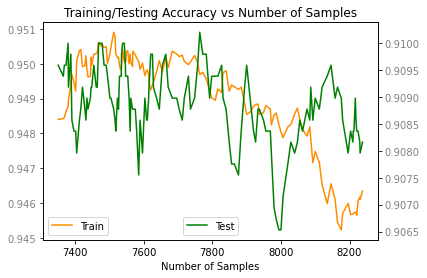

In [28]:
import matplotlib.pyplot as plt
y1 = TrainAcc
y2 = TestAcc
x = samples_added
fig, ax = plt.subplots()

ax.plot(x, y1, color='darkorange', label="Train")
ax.tick_params(axis='y', labelcolor='gray')
ax.legend(loc="lower left")
ax2 = ax.twinx()
ax2.plot(x, y2, color='green', label="Test")
ax2.tick_params(axis='y', labelcolor='gray')
ax2.legend(loc='lower center')
ax.set_xlabel("Number of Samples")
plt.title("Training/Testing Accuracy vs Number of Samples")
plt.savefig("al_plot.png", dpi=300)
plt.show()